<a href="https://colab.research.google.com/github/HarshaIndukuri/21cs460_group16/blob/main/ERU_Net_Crater_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing libraries
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

In [ ]:
#accessing moon images and masks from drive
train_images_path = r'/content/drive/MyDrive/Colab Notebooks/DEM and images/train_images.hdf5'
f = h5.File(train_images_path,'r')

In [ ]:
#converting hdf5 columns to numpy array and taking a portion as training set
#training set of of size 10000 images and masks
training_images = np.array(f['input_images'][:15000])
training_masks = np.array(f['target_masks'][:15000])

In [ ]:
#validation images and masks (picking 3000 images and masks)
valid_images = np.array(f['input_images'][20000:25000])
valid_masks =  np.array(f['target_masks'][20000:25000])

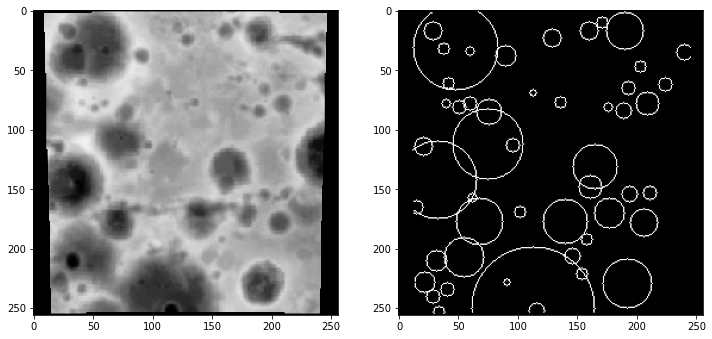

In [ ]:
#showing sample dem-target pair
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(training_images[20], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(training_masks[20], origin='upper', cmap='Greys_r')
plt.show()

In [ ]:
#first import the functions we need from keras
from keras.models import Model
from keras.layers import BatchNormalization,Input,Add
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPool2D
from keras.layers.merge import concatenate

The Architecture we are going to follow: 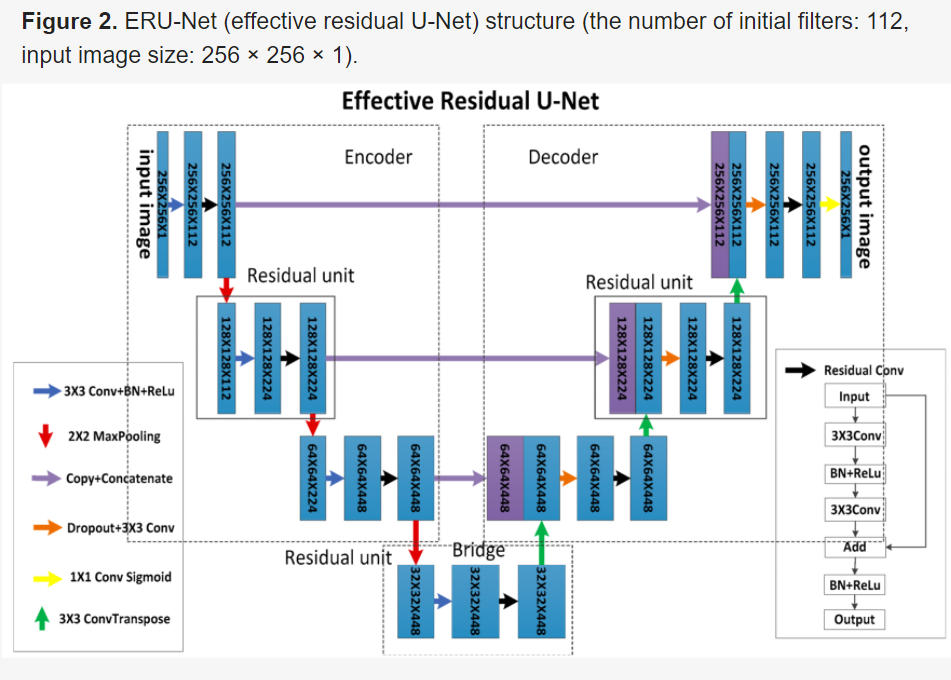
[found here](https://www.mdpi.com/2072-4292/12/17/2694/htm):

In [ ]:
#Creating all functions needed to make ERU-Net

#residual conv in diagram
def res_conv(inputs,kernels):
  l = Conv2D(kernels,(3,3),activation='relu',padding='same')(inputs)
  l = BatchNormalization()(l)
  l = Conv2D(kernels,(3,3),activation='relu',padding='same')(l)
  s = Add()([l,inputs])
  s = BatchNormalization()(s)
  s = Conv2D(kernels,(3,3),activation='relu',padding='same')(s)
  return s

#residual unit in encoder part of diagram
def res_block(inputs,kernels):
  l = Conv2D(kernels,(3,3),activation='relu',padding='same')(inputs)
  l = res_conv(l,kernels)
  return l 

def res_block_pool(inputs,kernels):
  o = res_block(inputs,kernels)
  p = MaxPool2D((2,2))(o)
  return o,p

#residual unit in decoder part, dropouts added
def res_block2(inputs,kernels):
  l = Dropout(0.15)(inputs)
  l = res_block(l,kernels)
  return l

#transpose convolution and concatenation
def blow_up(inputs,skip_inputs,kernels):
   l = Conv2DTranspose(kernels,(3,3),strides = (2,2),padding = 'same')(inputs)
   l = concatenate([skip_inputs,l])
   l = res_block2(l,kernels)
   return l


In [ ]:
#making the eru-net
def make_erunet(input_shape,k): #k being number of filters in 1st layer
  inputs = Input(shape = input_shape)

  r1,p1 = res_block_pool(inputs,k)
  r2,p2 = res_block_pool(p1,2*k)
  r3,p3 = res_block_pool(p2,4*k)

  bridge = res_block(p3,4*k)

  t1 = blow_up(bridge,r3,4*k)
  t2 = blow_up(t1,r2,2*k)
  t3 = blow_up(t2,r1,k)

  output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(t3) #final output,using sigmoid as shown in figure

  model = Model(inputs,output,name='Lunar_ERU_Net')
  return model

In [ ]:
image_shape = (256,256,1)
k = 56 #as shown in figure above, first layer of has 112 filters but we are using just 56
enet = make_erunet(image_shape,k)
enet.summary()

Model: "Lunar_ERU_Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 56  560         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 256, 256, 56  28280       ['conv2d_29[0][0]']              
                                )                                                     

In [ ]:
#setting the loss we want to optimise our model with (using binary cross entropy because at the pixel level this problem is a two class classfication)
enet.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.BinaryAccuracy(threshold = 0.5),keras.metrics.MeanIoU(num_classes = 2)])

In [ ]:
valid_data = (valid_images,valid_masks)
history = enet.fit(x=training_images,y=training_masks,validation_data = valid_data,epochs = 1,batch_size = 10)

1500/1500 [==============================] - 12388s 8s/step - loss: 0.0957 - binary_accuracy: 0.9708 - mean_io_u_1: 0.4855 - val_loss: 0.0893 - val_binary_accuracy: 0.9719 - val_mean_io_u_1: 0.4857


In [ ]:
#predictions for test set(taking 1000 images as test set)
test_images = np.array(f['input_images'][15000:16000])
test_preds1 = enet.predict(test_images)

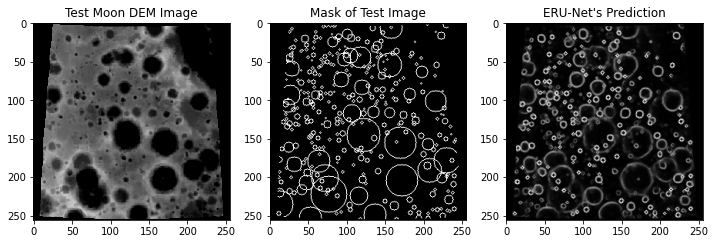

In [ ]:
#sample test image and mask, and u-net's prediction
test1 = test_preds1[20]
test1 = test1.reshape(256,256) #reshaping required
fig = plt.figure(figsize=[12, 6])
[ax1,ax2,ax3] = fig.subplots(1,3)
ax1.imshow(test_images[20], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(f['target_masks'][15020][...], origin='upper', cmap='Greys_r')
ax3.imshow(test1, origin='upper', cmap='Greys_r', vmin=0, vmax=0.8)
ax1.set_title('Test Moon DEM Image')
ax2.set_title('Mask of Test Image')
ax3.set_title("ERU-Net's Prediction")
plt.show()

In [ ]:
#saving trained model
enet.save('lunar_enet.h5')
#saving to drive also
import shutil
shutil.copy('/content/lunar_enet.h5','/content/drive/MyDrive/trained models')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


'/content/drive/MyDrive/trained models/lunar_enet.h5'

In [ ]:
#getting our U-Net to compare eru-net with
unet = keras.models.load_model('/content/drive/MyDrive/trained models/lunar_net.h5')
test_masks = np.array(f['target_masks'][15000:16000])
test_preds2 = unet.predict(test_images)

In [ ]:
#iou for eru-net and u-net
m1 = keras.metrics.MeanIoU(num_classes=2)
m1.update_state(test_masks,test_preds1)
m2 = keras.metrics.MeanIoU(num_classes=2)
m2.update_state(test_masks,test_preds2)
print("Mean IoU for ERU-Net over 1000 unseen images is " + str(m1.result().numpy()))
print("Mean IoU for U-Net over 1000 unseen images is " + str(m2.result().numpy()))

Mean IoU for ERU-Net over 1000 unseen images is 0.44804814
Mean IoU for U-Net over 1000 unseen images is 0.44804814


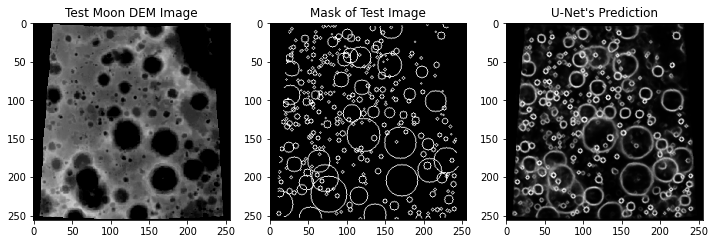

In [ ]:
test2 = test_preds2[20].reshape(256,256)
fig = plt.figure(figsize=[12, 6])
[ax1,ax2,ax3] = fig.subplots(1,3)
ax1.imshow(f['input_images'][15020][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(f['target_masks'][15020][...], origin='upper', cmap='Greys_r')
ax3.imshow(test2, origin='upper', cmap='Greys_r', vmin=0, vmax=0.8)
ax1.set_title('Test Moon DEM Image')
ax2.set_title('Mask of Test Image')
ax3.set_title("U-Net's Prediction")
plt.show()